In [1]:
from Methods.Adams import adams
from Methods.Euler import euler
from Methods.AdamsBashfortMoulton import abm
from Methods.PredictorCorrector import predictor_corrector as pred_corr
from Methods.RungeKutt import rk_a,rk_b
from Methods.Gir import gir
import numpy as np

In [2]:
def fi(x):
    return np.sin(np.exp(x))


def dfi(x):
    return np.exp(x) * np.cos(np.exp(x))


def f(x, y):
    return dfi(x) + k * (y - fi(x))
from matplotlib import pyplot as plt

def solution_plot(nodes,y1,y2, y1_name = 'y1', y2_name = 'y2', title = '', fig = None):
    if fig is None:
        fig = plt.figure()
    plt.title(title)
    plt.plot(nodes, y1, label=y1_name, linewidth=1)
    plt.plot(nodes, y2, label=y2_name, linewidth=1)
    plt.legend(loc='lower left')
    plt.show()
    return fig

In [3]:
class Method:
    def __init__(self, x0,xN,k,N, method_f,p,
                 require_additional = False, fi = None,dfi= None, name = 'y2',
                 _lambda = 0.1, is_iter = False, starter = None):
        self.x0 = x0
        self.xN = xN
        self.k = k
        self.N = N
        self.require_additional = require_additional
        self.method_f = method_f
        self.fi = fi
        self.dfi = dfi
        self.name = name
        self._lambda = _lambda
        self.is_iter = is_iter
        self.starter = starter
        self.p = p
        
    def calculate(self,initial_y,f, N = -1):
        if N == -1:
            N = self.N
        result = np.zeros(N)
        nodes = np.linspace(x0, xN, N)
        
        if not (self.starter is None):
            self.starter.x0 = self.x0
            self.starter.xN = nodes[self.starter.N-1]
            initial_y = self.starter.calculate(initial_y,f)
            
        nodes = np.linspace(x0, xN, N)
        
        if self.require_additional:
            result = self.method_f(nodes,initial_y,f,fi,k,dfi)
        elif self.is_iter:
            result = self.method_f(nodes,initial_y,self._lambda,f)
        else:
            result = self.method_f(nodes,initial_y,f)
        return result
    
    def form_title(self):
        result = ''
        if self.require_additional:
            result = self.name + ', N = '+ str(self.N)
        elif self.is_iter:
            result = self.name + ', L='+ str(self._lamda)+',N = '+ str(self.N)
        else:
            result = self.name + ', N = '+ str(self.N)
        

In [4]:
N = 5 * 2 ** 1
_N = 5 * 2 ** 6

draw_step = max(1,int(N/_N))


k = 0
x0 = -1
xN = 2

euler_method = Method(x0,xN,k,N,euler,1, name = 'явный метод Эйлера')
adams_method = Method(x0,xN,k,N,adams,4, name = 'явный метод Адамса')
pc_method = Method(x0,xN,k,N,pred_corr,2, name = 'метод типа предиктор-корректор', is_iter = True, _lambda = 0.01)
abm_method = Method(x0,xN,k,N,abm,4, name = 'метод Адамса-Бэшфорта-Моултона')
rka_method = Method(x0,xN,k,N,rk_a,3, name = 'метод Рунге-Кутты O(h^3)')
rkb_method = Method(x0,xN,k,N,rk_b,4, name = 'метод Рунге-Кутты O(h^4)')
gir_method = Method(x0,xN,k,N,gir,4,require_additional = True, fi = fi,dfi= dfi, name = 'метод Гира')

methods = [euler_method,adams_method,pc_method,abm_method,abm_method,rka_method,rkb_method,gir_method]

In [5]:

nodes = np.linspace(x0, xN, N)
y_fi = fi(nodes)
#nodes_draw = nodes[::draw_step]
y_fi_draw = y_fi[::draw_step]
'''
y_euler = euler_method.calculate(fi(x0),f)
y_adams = adams_method.calculate(y_fi[:4],f)
y_pc = pc_method.calculate(fi(x0),f)
y_abm = abm_method.calculate(y_fi[:4],f)
y_rka = rk_a(nodes, fi(x0),f)
y_rkb = rk_b(nodes, fi(x0),f)
y_gir = gir(nodes,y_fi[:4],f, fi, k, dfi)

solution_plot(nodes_draw,y_fi_draw,y_euler[::draw_step], y2_name = 'явный метод Эйлера', title = 'EEE')
solution_plot(nodes_draw,y_fi_draw,y_adams[::draw_step], y2_name = 'явный метод Адамса')
solution_plot(nodes_draw,y_fi_draw,y_pc[::draw_step], y2_name = 'метод типа предиктор-корректор')
solution_plot(nodes_draw,y_fi_draw,y_abm[::draw_step], y2_name = 'метод Адамса-Бэшфорта-Моултона')
solution_plot(nodes_draw,y_fi_draw,y_rka[::draw_step], y2_name = 'метод Рунге-Кутты h^3')
solution_plot(nodes_draw,y_fi_draw,y_rkb[::draw_step], y2_name = 'метод Рунге-Кутты h^4')
solution_plot(nodes_draw,y_fi_draw,y_gir[::draw_step], y2_name = 'метод Гира')
'''

"\ny_euler = euler_method.calculate(fi(x0),f)\ny_adams = adams_method.calculate(y_fi[:4],f)\ny_pc = pc_method.calculate(fi(x0),f)\ny_abm = abm_method.calculate(y_fi[:4],f)\ny_rka = rk_a(nodes, fi(x0),f)\ny_rkb = rk_b(nodes, fi(x0),f)\ny_gir = gir(nodes,y_fi[:4],f, fi, k, dfi)\n\nsolution_plot(nodes_draw,y_fi_draw,y_euler[::draw_step], y2_name = 'явный метод Эйлера', title = 'EEE')\nsolution_plot(nodes_draw,y_fi_draw,y_adams[::draw_step], y2_name = 'явный метод Адамса')\nsolution_plot(nodes_draw,y_fi_draw,y_pc[::draw_step], y2_name = 'метод типа предиктор-корректор')\nsolution_plot(nodes_draw,y_fi_draw,y_abm[::draw_step], y2_name = 'метод Адамса-Бэшфорта-Моултона')\nsolution_plot(nodes_draw,y_fi_draw,y_rka[::draw_step], y2_name = 'метод Рунге-Кутты h^3')\nsolution_plot(nodes_draw,y_fi_draw,y_rkb[::draw_step], y2_name = 'метод Рунге-Кутты h^4')\nsolution_plot(nodes_draw,y_fi_draw,y_gir[::draw_step], y2_name = 'метод Гира')\n"

In [87]:
def runge_rule(p,yh_2,yh):    
    return ((2**p)/(2**p -1) ) * (yh_2 - yh)

def compare(y1,y2):
    n = y1
    eps_global = np.abs(y1 - y2) 
    eps_local = eps_global / np.maximum(np.abs(y1),np.abs(y2))
    eps_max = np.max(eps_global)
    return eps_global,eps_local,eps_max



In [88]:
method = adams_method
p = method.p
yh = method.calculate(y_fi[:4],f)
yh_2 = method.calculate(y_fi[:4],f, N = method.N * 2)[::2]
print(np.max(np.abs(runge_rule(p,yh,yh_2))))

_,_,eps_max = compare(y_fi,yh)
print(eps_max)

1.6796925686394297
1.1233357523889014


5
10
20
40


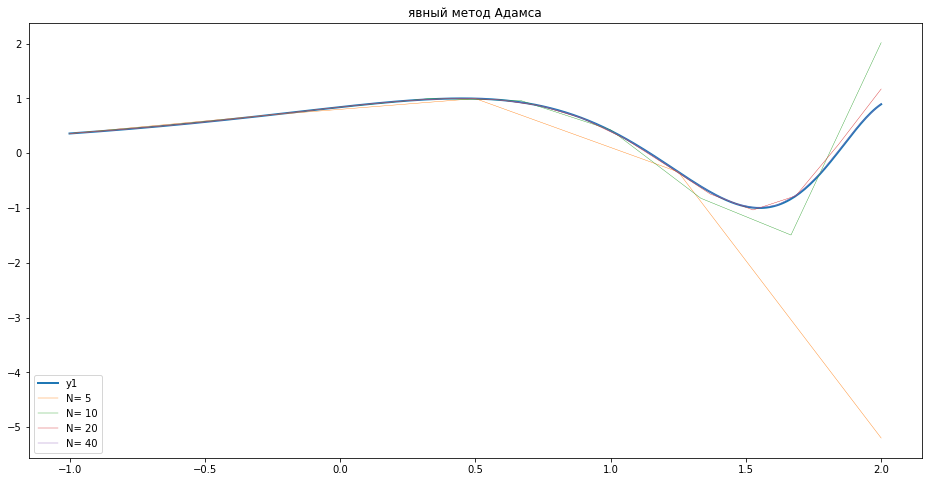

In [113]:
N_start = 5
method = adams_method


fig = plt.figure(figsize=(16,8))
plt.title(method.name)


nodes_draw = np.linspace(method.x0, method.xN, _N)


plt.plot(nodes_draw, fi(nodes_draw), label='y1', linewidth=2)

    
for i in range(0,4):
    current_n = int(N_start * (2**(i)))
    print(current_n)
    nodes = np.linspace(method.x0, method.xN, current_n)
    
    y = adams_method.calculate(fi(nodes)[:4],f, N = current_n )
    plt.plot(nodes, y, label='N= '+str(current_n), linewidth=0.4)

plt.legend(loc='lower left')
#plt.show()
plt.savefig('test.png',dpi = 200)

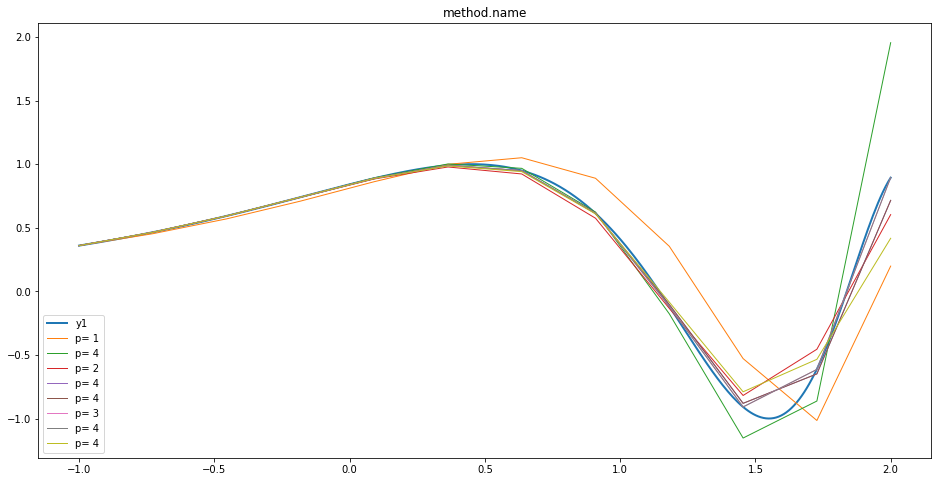

In [43]:
current_n = 12
nodes = np.linspace(x0, xN, current_n)
y = adams_method.calculate(y_fi[:4],f)

fig = plt.figure(figsize=(16,8))
plt.title('method.name')

nodes_draw = np.linspace(x0, xN, _N)
plt.plot(nodes_draw, fi(nodes_draw), label='y1', linewidth=2)

for method in methods:
    y = method.calculate(fi(nodes)[:4],f, N = current_n )
    plt.plot(nodes, y, label='p= '+str(method.p), linewidth=1)
    
plt.legend(loc='lower left')
#plt.show()
plt.savefig('test1.png',dpi = 200)

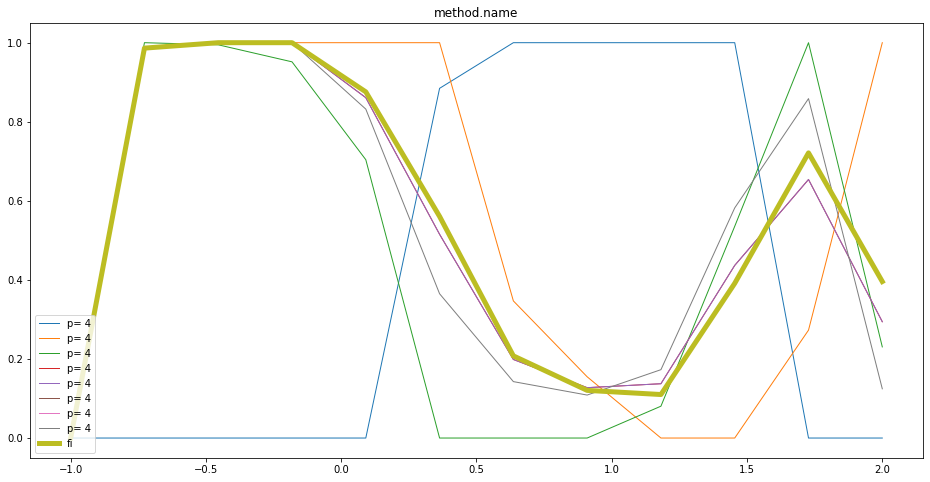

In [49]:
current_n = 12
nodes = np.linspace(x0, xN, current_n)
y = adams_method.calculate(y_fi[:4],f)

fig = plt.figure(figsize=(16,8))
plt.title('method.name')

nodes_draw = np.linspace(x0, xN, current_n)
y_fi = fi(nodes_draw)



ys = []

for method in methods:
    y = method.calculate(fi(nodes)[:4],f, N = current_n )
    ys.append(y-y_fi)
    #plt.plot(nodes, y, label='p= '+str(method.p), linewidth=1)
y_max = ys[0]
y_min = ys[0]
for y in ys:
    y_max = np.maximum(y_max,y)
    y_min = np.minimum(y_min,y)

y_delta = y_max - y_min
y_delta[0] = 1
for i in range(len(ys)):
    ys[i] = (ys[i]-y_min) / (y_delta)
#ys.append((-y_min) / (y_delta))
#print(y_delta)



for y in ys:
    plt.plot(nodes, y, label='p= '+str(method.p), linewidth=1)
plt.plot(nodes,(-y_min) / (y_delta),label='fi', linewidth=5)   
plt.legend(loc='lower left')
#plt.show()
plt.savefig('test3.png',dpi = 200)